In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [177]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data 
    try:
        self.grad = torch.zeros(data.shape)  # 0.0
    except:
        self.grad = torch.zeros(1)
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data}, label={self.label})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, _children=(self, other), _op='+')

    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward

    return out

  def __radd__(self, other):
    return self + other

  def __neg__(self):
    return self * (-1)

  def __sub__(self, other):
    return self + -other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, _children=(self, other), _op='*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, _children=(self,), _op=f'**{other}')

    def _backward():
      self.grad += other*self.data**(other-1) * out.grad
    out._backward = _backward

    return out

  def __truediv__(self, other):
    return self * other**(-1)

  def tanh(self):
    t = (np.exp(2*self.data)-1) / (np.exp(2*self.data)+1)
    out = Value(t, _children=(self,), _op='tanh')
    def _backward():
      self.grad += (1-t**2) * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def exp(self):
    e = np.exp(self.data)
    out = Value(e, _children=(self,), _op='exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def trace(self):
    t = 0
    for i in range(len(self.data)):
        t += self.data[i,i]
    out = Value(t, _children=(self,), _op='trace')
    def _backward():
        self.grad += torch.eye(len(self.data)) * out.grad
        print('ha7na')
    out._backward = _backward
    return out

  # most important method
  def backward(self):
    topo = []
    visited = set()
    def topo_sort(node):
      if node not in visited:
        visited.add(node)
        for child in node._prev:
          topo_sort(child)
        topo.append(node)

    topo_sort(self)
    self.grad = 1.0
    for node in reversed(topo):
      print('node', node)
      node._backward()


In [178]:
a = torch.rand((2,2))
b = torch.rand((2,2))
a.requires_grad = True
b.requires_grad = True
print(a)
print()
print(b)

tensor([[0.3251, 0.1118],
        [0.6071, 0.5368]], requires_grad=True)

tensor([[0.9688, 0.1707],
        [0.5806, 0.2206]], requires_grad=True)


In [179]:
loss = torch.trace(a)
loss

tensor(0.8619, grad_fn=<TraceBackward0>)

In [180]:
loss.backward()

In [181]:
a.grad

tensor([[1., 0.],
        [0., 1.]])

In [182]:
a = Value(a, label='a')
b = Value(b)
loss = (a).trace(); loss.label='loss'
loss

Value(data=0.8618749380111694, label=loss)

In [183]:
loss.backward()

node Value(data=0.8618749380111694, label=loss)
ha7na
node Value(data=tensor([[0.3251, 0.1118],
        [0.6071, 0.5368]], requires_grad=True), label=a)


In [184]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(node):
      if node not in nodes:
        nodes.add(node)
        for child in node._prev:
          # nodes.add(child) # bad idea
          edges.add((child, node))
          build(child)
    build(root)
    return nodes, edges

def draw_graph(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
  nodes, edges = trace(root)

  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = f"{n.label}|data {n.data}|grad {n.grad}", shape='record')
    if n._op:
      dot.node(name = uid + n._op, label=n._op)
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    uid1, uid2 = str(id(n1)), str(id(n2))
    dot.edge(uid1, uid2+n2._op)

  return dot
    
nodes, edges = trace(loss)
print('nodes', nodes)
print('edges', edges)

nodes {Value(data=0.8618749380111694, label=loss), Value(data=tensor([[0.3251, 0.1118],
        [0.6071, 0.5368]], requires_grad=True), label=a)}
edges {(Value(data=tensor([[0.3251, 0.1118],
        [0.6071, 0.5368]], requires_grad=True), label=a), Value(data=0.8618749380111694, label=loss))}


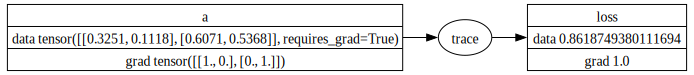

In [185]:
draw_graph(loss)

Mchit ntalel fo9 sor khroj 3liya a Tensor
---

In [ ]:
class Tensor:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        

In [ ]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(node):
      if node not in nodes:
        nodes.add(node)
        for child in node._prev:
          # nodes.add(child) # bad idea
          edges.add((child, node))
          build(child)
    build(root)
    return nodes, edges

def draw_graph(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
  nodes, edges = trace(root)

  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = f"{n.label}|data {n.data: .4f}|grad {n.grad: .4f}", shape='record')
    if n._op:
      dot.node(name = uid + n._op, label=n._op)
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    uid1, uid2 = str(id(n1)), str(id(n2))
    dot.edge(uid1, uid2+n2._op)

  return dot

In [ ]:
x1 = Value(1, label='x1')
x2 = Value(0, label='x2')
w1 = Value(-0.7, label='w1')
w2 = Value(0.2, label='w2')
b = Value(0.45, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
in_prod = x1w1 + x2w2; in_prod.label='x1w1 + x2w2'
n = in_prod + b; n.label='n'
e = (2*n).exp()
o = (e -1) / (e + 1); o.label='o'
# o = n.tanh(); o.label='o'
o.backward()

In [ ]:
draw_graph(o)

In [ ]:
class Neuron:
  def __init__(self, n_input):
    self.w = [Value(np.random.uniform(-1,1)) for _ in range(n_input)]
    self.b = Value(np.random.uniform(-1,1), label='b')

  def __call__(self, x):
    out = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
    return out.tanh()

  def parameters(self):
    return self.w

class Layer:
  def __init__(self, n_input, n_out):
    self.neurons = [Neuron(n_input) for _ in range(n_out)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      params.extend(neuron.parameters())
    return params

class MLP:
  def __init__(self, n_input, n_outs):
    self.layers = []
    self.layers.append(Layer(n_input, n_outs[0]))
    for i in range(len(n_outs)-1):
      l = Layer(n_outs[i], n_outs[i+1])
      self.layers.append(l)

  def __call__(self, x):
    z = x
    for layer in self.layers:
      z = layer(z)
    return z

  def parameters(self):
    params = []
    for layer in self.layers:
      layer_param = layer.parameters()
      params.extend(layer.parameters())
    return params

In [ ]:
def mse_loss(ypred, ytrue):
  loss = sum((ypred_i - ytrue_i)**2 for ypred_i, ytrue_i in zip(ypred, ytrue))
  return loss

In [ ]:
xs = [[2,3,-1],
      [3,-1,0.5],
      [0.5,1,1],
      [1,1,-1]]

ys = [1.0,-1.0,-1.0,1.0]
model = MLP(3, [4,4,1])

In [ ]:
lr = 0.1

loss_all = 0

for epoch in range(100):
    # forward pass
    ypreds = [model(x) for x in xs]
    loss = mse_loss(ypreds, ys)

    # backward pass
    loss.backward()

    # update
    params = model.parameters()
    # print(f'grad {params[0].grad: 0.4f}')
    for p in model.parameters():
      p.data -= lr*p.grad
      p.grad = 0.0

    if epoch % 5 == 0:
      print(f'epoch {epoch}, loss {loss.data: 0.4f}')



In [ ]:
outs = [model(x) for x in xs]
outs

Moon Dataset - MLP
---

In [ ]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [ ]:
model = MLP(2, [10,10,1])
print(f'number of params: {len(model.parameters())}')

In [ ]:
lr = 0.01

loss_all = 0

for epoch in range(100):
    # forward pass
    ypreds = [model(x) for x in X]
    loss = mse_loss(ypreds, y)

    # backward pass
    for p in model.parameters():
      p.grad = 0.0

    loss.backward()

    # update
    for p in model.parameters():
      p.data -= lr*p.grad

    if epoch % 5 == 0:
      print(f'epoch {epoch}, loss {loss.data: 0.4f}')

In [ ]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

MNIST dataset - MLP
---

In [ ]:
# from torchvision.datasets import MNIST
# import torchvision.transforms as T
# import torch
# import torchvision

# DATASET_PATH = "./data"

# # Transform to normalized Tensors in the range [0,1]
# MNIST_train_dataset = MNIST(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))
# MNIST_test_dataset = MNIST(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))

In [ ]:
# # Visualize some examples
# NUM_IMAGES = 12
# MNIST_images = torch.stack([MNIST_train_dataset[np.random.randint(len(MNIST_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
# img_grid = torchvision.utils.make_grid(MNIST_images, nrow=6, normalize=True, pad_value=0.9)
# img_grid = img_grid.permute(1, 2, 0)

# plt.figure(figsize=(8,8))
# plt.title("Image examples of the MNIST dataset")
# plt.imshow(img_grid)
# plt.axis('off')
# plt.show()
# plt.close()

In [ ]:
# n_samples = 10
# MNIST_Xtrain_255 = MNIST_train_dataset.data.numpy()
# MNIST_ytrain_255 = MNIST_train_dataset.targets.numpy()

# MNIST_Xtrain_255 = MNIST_Xtrain_255[:n_samples]
# MNIST_ytrain_255 = MNIST_ytrain_255[:n_samples]

In [ ]:
# X = MNIST_Xtrain_255/255
# y = MNIST_ytrain_255

In [ ]:
# for x in X:
#   print(x.flatten().shape)
#   # print(x)
#   break

In [ ]:
# model = MLP(28*28, [30,30,10])
# print(f'number of params: {len(model.parameters())}')

In [ ]:
# ypreds = [model(x.flatten()) for x in X]

In [ ]:
# y

In [ ]:
# lr = 0.01

# loss_all = 0

# for epoch in range(10):
#     # forward pass
#     ypreds = [model(x.flatten()) for x in X]
#     loss = mse_loss(ypreds, y)

#     # backward pass
#     for p in model.parameters():
#       p.grad = 0.0

#     loss.backward()

#     # update
#     for p in model.parameters():
#       p.data -= lr*p.grad

#     if epoch % 1 == 0:
#       print(f'epoch {epoch}, loss {loss.data: 0.4f}')